---
# <div align="center"><font color='red'>  </font></div>
# <div align="center"><font color='red'> COSC 2779/2972 | Deep Learning  </font></div>
## <div align="center"> <font color='red'> Week 7 Lectorial Example: **Modelling Sequential (Time Series) Data**</font></div>
---

In this example we will use the CoNLL-2003 dataset to do **Named Entity recognition (NER)**.
The CoNLL-2003 task concerns language-independent named entity recognition - we will only use the English dataset for this example. There are four types of named entities: 
1. persons (PER)
2. locations (LOC)
3. organizations (ORG)
4. names of miscellaneous entities that do not belong to the previous three groups (MISC).

A word with tag O is not part of a phrase.

The CoNLL-2003 task data files contain four columns separated by a single space. Each word has been put on a separate line and there is an empty line after each sentence. The first item on each line is a word, the second a part-of-speech (POS) tag, the third a syntactic chunk tag and the fourth the named entity tag. The chunk tags and the named entity tags have the format I-TYPE which means that the word is inside a phrase of type TYPE. Only if two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE to show that it starts a new phrase. A word with tag O is not part of a phrase. 



| Word | Part-of-speech | Syntactic chunk | Named Entity Tag|
|----------|---------|----------|--------|
| U.N.  |       NNP|  I-NP|  I-ORG| 
|official|     NN|   I-NP|  O |
|Ekeus|        NNP|  I-NP|  I-PER| 
|heads|        VBZ|  I-VP|  O |
|for |         IN|   I-PP|  O |
|Baghdad|      NNP|  I-NP|  I-LOC |
|.    |        .|    O|     O |

The example is partly based on the Blog post [Named Entity Recognition with RNNs in TensorFlow](http://alexminnaar.com/2019/08/22/ner-rnns-tensorflow.html) by Alex Minnaar.

## Download the dataset

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
!wget "https://data.deepai.org/conll2003.zip"

--2022-09-01 06:03:09--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 5.9.140.253
Connecting to data.deepai.org (data.deepai.org)|5.9.140.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/x-zip-compressed]
Saving to: ‘conll2003.zip.4’

conll2003.zip.4     100%[===================>] 959.94K  2.04MB/s    in 0.5s    

2022-09-01 06:03:09 (2.04 MB/s) - ‘conll2003.zip.4’ saved [982975/982975]



In [3]:
!unzip -qq -o conll2003.zip

## Reading data and preprocessing

In [4]:
labels = set()

def file2Examples(file_name):
  '''
  Read data files and return input/output pairs
  '''
  
  examples=[]

  with open(file_name,"r") as f:

    next(f)
    next(f)

    example = [[],[]]

    for line in f:

      input_output_split= line.split()

      if len(input_output_split)==4:
        example[0].append(input_output_split[0])
        example[1].append(input_output_split[-1])
        labels.add(input_output_split[-1])

      elif len(input_output_split)==0:
        examples.append(example)
        example=[[],[]]
      else:
        example=[[],[]]

    f.close()
    
    return examples

Extract examples from train, validation, and test files 

In [5]:
train_examples = file2Examples("train.txt")
test_examples = file2Examples("test.txt")
valid_examples = file2Examples("valid.txt")

In [6]:
train_examples[0]

[['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.'],
 ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']]

In [7]:
train_examples[12]

[['Only',
  'France',
  'and',
  'Britain',
  'backed',
  'Fischler',
  "'s",
  'proposal',
  '.'],
 ['O', 'B-LOC', 'O', 'B-LOC', 'O', 'B-PER', 'O', 'O', 'O']]

Some stats

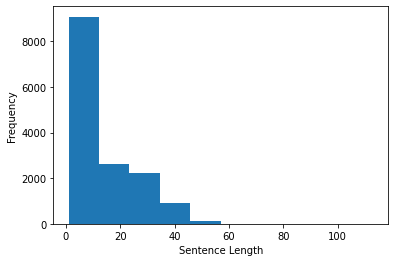

In [8]:
import numpy as np
import matplotlib.pyplot as plt
sentance_lens = [len(x) for x,y in train_examples]

plt.hist(sentance_lens)
plt.ylabel("Frequency")
plt.xlabel("Sentence Length")
plt.show()

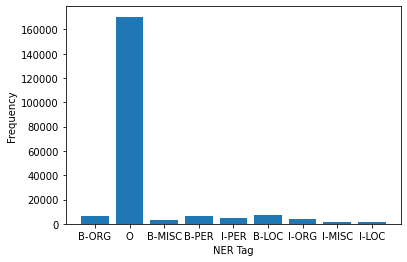

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import collections

labels_ = list()
for x,y in train_examples:
  labels_ = labels_ + y

frequency = collections.Counter(labels_)

plt.bar(frequency.keys(), frequency.values())
plt.ylabel("Frequency")
plt.xlabel("NER Tag")
plt.show()

Whithout O tag

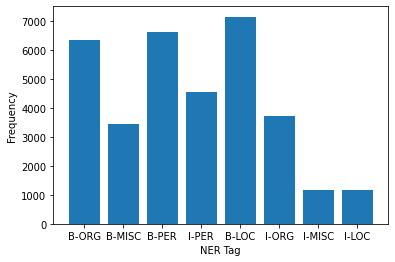

In [10]:
frequency.pop('O', None)
plt.bar(frequency.keys(), frequency.values())
plt.ylabel("Frequency")
plt.xlabel("NER Tag")
plt.show()

Create character vocab and map characters and labels to integers

In [11]:
# create character vocab
all_text = " ".join([" ".join(x[0]) for x in train_examples+valid_examples+test_examples])
vocab = sorted(set(all_text))

# create character/id and label/id mapping
char2idx = {u:i+1 for i, u in enumerate(vocab)}
idx2char = np.array(vocab)
label2idx = {u:i+1 for i, u in enumerate(labels)}
idx2label = np.array(labels)

print(label2idx)
print(char2idx)

{'B-LOC': 1, 'I-PER': 2, 'B-PER': 3, 'I-ORG': 4, 'B-MISC': 5, 'I-LOC': 6, 'I-MISC': 7, 'B-ORG': 8, 'O': 9}
{' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '=': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, ']': 59, '`': 60, 'a': 61, 'b': 62, 'c': 63, 'd': 64, 'e': 65, 'f': 66, 'g': 67, 'h': 68, 'i': 69, 'j': 70, 'k': 71, 'l': 72, 'm': 73, 'n': 74, 'o': 75, 'p': 76, 'q': 77, 'r': 78, 's': 79, 't': 80, 'u': 81, 'v': 82, 'w': 83, 'x': 84, 'y': 85, 'z': 86}


In [12]:
def split_char_labels(eg):
  '''
  For a given input/output example, break tokens into characters while keeping 
  the same label.
  '''

  tokens = eg[0]
  labels= eg[1]

  input_chars = []
  output_char_labels = []

  for token,label in zip(tokens,labels):

    input_chars.extend([char for char in token])
    input_chars.extend(' ')
    output_char_labels.extend([label]*len(token))
    output_char_labels.extend('O')

  return [[char2idx[x] for x in input_chars[:-1]],np.array([label2idx[x] for x in output_char_labels[:-1]])]

train_formatted = [split_char_labels(eg) for eg in train_examples]
test_formatted = [split_char_labels(eg) for eg in test_examples]
valid_formatted = [split_char_labels(eg) for eg in valid_examples]

print(len(train_formatted))
print(len(test_formatted))
print(len(valid_formatted))

14986
3683
3465


## Setup Data generators

In [13]:
# training generator
def gen_train_series():

    for eg in train_formatted:
      yield eg[0],eg[1]

# validation generator
def gen_valid_series():

    for eg in valid_formatted:
      yield eg[0],eg[1]

# test generator
def gen_test_series():

  for eg in test_formatted:
      yield eg[0],eg[1]
  
# create Dataset objects for train, test and validation sets  
series = tf.data.Dataset.from_generator(gen_train_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_valid = tf.data.Dataset.from_generator(gen_valid_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))
series_test = tf.data.Dataset.from_generator(gen_test_series,output_types=(tf.int32, tf.int32),output_shapes = ((None, None)))

BATCH_SIZE = 128
BUFFER_SIZE=1000

# create padded batch series objects for train, test and validation sets
ds_series_batch = series.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_valid = series_valid.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)
ds_series_batch_test = series_test.padded_batch(BATCH_SIZE, padded_shapes=([None], [None]), drop_remainder=True)

# print example batches
for input_example_batch, target_example_batch in ds_series_batch_valid.take(1):
  print(input_example_batch)
  print(target_example_batch)

tf.Tensor(
[[34 49 40 ...  0  0  0]
 [43 46 45 ...  0  0  0]
 [54 65 79 ...  0  0  0]
 ...
 [ 3  1 36 ...  0  0  0]
 [40 66  1 ...  0  0  0]
 [35 81 78 ...  0  0  0]], shape=(128, 228), dtype=int32)
tf.Tensor(
[[9 9 9 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [5 5 5 ... 0 0 0]
 ...
 [9 9 9 ... 0 0 0]
 [9 9 9 ... 0 0 0]
 [3 3 3 ... 0 0 0]], shape=(128, 228), dtype=int32)


## Create model

### RNN Cell

In [14]:
vocab_size = len(vocab)+1

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

label_size = len(labels)  

# build LSTM model
def build_model(vocab_size,label_size, embedding_dim, rnn_units, batch_size):
      model = tf.keras.Sequential([
          tf.keras.layers.Embedding(vocab_size, embedding_dim,
                            batch_input_shape=[batch_size, None],mask_zero=True),
          tf.keras.layers.SimpleRNN(rnn_units,
                      return_sequences=True,
                      stateful=True,
                      recurrent_initializer='glorot_uniform'),
          tf.keras.layers.Dense(label_size, activation='softmax')
          ])
      return model

model = build_model(
      vocab_size = len(vocab)+1,
      label_size=len(labels)+1,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units,
      batch_size=BATCH_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (128, None, 256)          22272     
                                                                 
 simple_rnn (SimpleRNN)      (128, None, 1024)         1311744   
                                                                 
 dense (Dense)               (128, None, 10)           10250     
                                                                 
Total params: 1,344,266
Trainable params: 1,344,266
Non-trainable params: 0
_________________________________________________________________


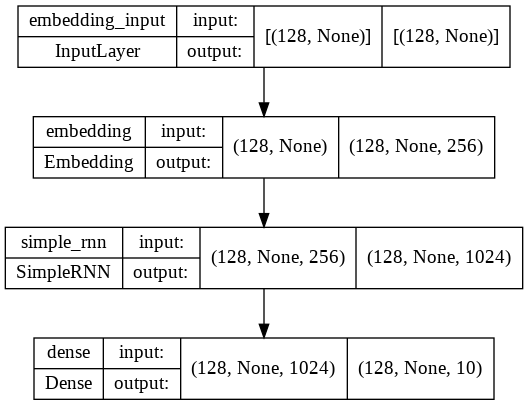

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

attach loss and optimizer

In [16]:
import os

# define loss function
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=False)

model.compile(optimizer='adam', loss=loss,metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

**is the loss and metric selected appropriate for the task?**

In [17]:
from itertools import cycle
def plotter(history_hold, metric = 'binary_crossentropy', ylim=[0.0, 1.0]):
  cycol = cycle('bgrcmk')
  for name, item in history_hold.items():
    y_train = item.history[metric]
    y_val = item.history['val_' + metric]
    x_train = np.arange(0,len(y_val))

    c=next(cycol)

    plt.plot(x_train, y_train, c+'-', label=name+'_train')
    plt.plot(x_train, y_val, c+'--', label=name+'_val')

  plt.legend()
  plt.xlim([1, max(plt.xlim())])
  plt.ylim(ylim)
  plt.xlabel('Epoch')
  plt.ylabel(metric)
  plt.grid(True)

train model

In [ ]:
EPOCHS=20
m_histories = {}

m_histories['RNN model'] = model.fit(ds_series_batch, 
                                     epochs=EPOCHS, 
                                     validation_data=ds_series_batch_valid,
                                     callbacks=[checkpoint_callback])

Epoch 1/20
117/117 [==============================] - 40s 311ms/step - loss: 0.2755 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.2113 - val_sparse_categorical_accuracy: 0.7986
Epoch 2/20
117/117 [==============================] - 34s 291ms/step - loss: 0.1767 - sparse_categorical_accuracy: 0.8009 - val_loss: 0.1617 - val_sparse_categorical_accuracy: 0.8046
Epoch 3/20
117/117 [==============================] - 36s 306ms/step - loss: 0.1352 - sparse_categorical_accuracy: 0.8232 - val_loss: 0.1307 - val_sparse_categorical_accuracy: 0.8330
Epoch 4/20
117/117 [==============================] - 34s 287ms/step - loss: 0.1164 - sparse_categorical_accuracy: 0.8404 - val_loss: 0.1317 - val_sparse_categorical_accuracy: 0.8285
Epoch 5/20
117/117 [==============================] - 35s 296ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.8483 - val_loss: 0.1132 - val_sparse_categorical_accuracy: 0.8569
Epoch 6/20
117/117 [==============================] - 35s 294ms/step - loss: 0.1055 -

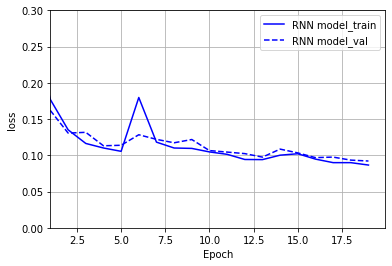

In [ ]:
plotter(m_histories, ylim=[0.0, 0.3], metric = 'loss')

### LSTM

In [ ]:
#TODO

## Testing

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = np.array([])
y_trues= np.array([])

# iterate through test set, make predictions based on trained model
for input_example_batch, target_example_batch in ds_series_batch_test:

  pred=model.predict_on_batch(input_example_batch)
  pred_max=tf.argmax(tf.nn.softmax(pred),2).numpy().flatten()
  y_true=target_example_batch.numpy().flatten()

  preds=np.concatenate([preds,pred_max])
  y_trues=np.concatenate([y_trues,y_true])

# remove padding from evaluation
remove_padding = [(p,y) for p,y in zip(preds,y_trues) if y!=0 and p!=0]

r_p = [x[0] for x in remove_padding]
r_t = [x[1] for x in remove_padding]

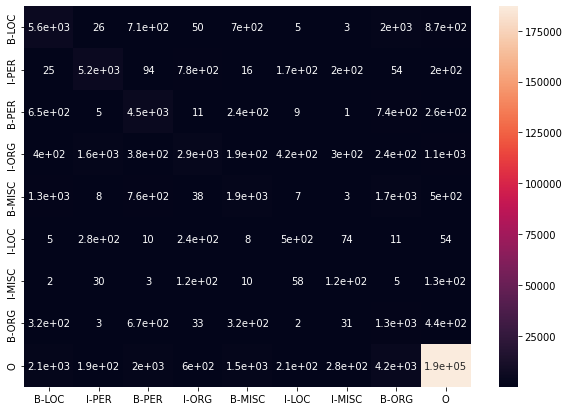

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(r_p,r_t)
df_cm = pd.DataFrame(conf_mat, 
                     index=list(idx2label.tolist()),
                     columns=list(idx2label.tolist()))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
print(classification_report(r_p,r_t,target_names=list(idx2label.tolist()) ))

              precision    recall  f1-score   support

       B-LOC       0.53      0.56      0.55      9962
       I-PER       0.71      0.77      0.74      6700
       B-PER       0.49      0.70      0.58      6377
       I-ORG       0.60      0.38      0.47      7461
      B-MISC       0.39      0.30      0.34      6194
       I-LOC       0.36      0.42      0.39      1185
      I-MISC       0.11      0.24      0.16       473
       B-ORG       0.13      0.42      0.19      3108
           O       0.98      0.94      0.96    197963

    accuracy                           0.87    239423
   macro avg       0.48      0.53      0.49    239423
weighted avg       0.90      0.87      0.88    239423



## Class Balance

In [ ]:
from sklearn.utils import class_weight

labels_ = list()
for x,y in train_formatted:
  labels_ = labels_ + list(y.tolist())


class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = range(1,10),
                                                  y = labels_)
class_weights = [1.0,] + class_weights.tolist()
class_weights

[1.0,
 2.656422189537462,
 4.112141910490366,
 3.1829133568309746,
 5.37049529557962,
 5.187909967845659,
 19.062381852551987,
 19.180218735140276,
 2.9899928343752316,
 0.1379654744273386]

In [ ]:
# class_weights = dict(zip(range(0,9), class_weights))
# class_weights

In [ ]:
model_cb = build_model(
      vocab_size = len(vocab)+1,
      label_size=len(labels)+1,
      embedding_dim=embedding_dim,
      rnn_units=rnn_units,
      batch_size=BATCH_SIZE)

In [ ]:
# define loss function
def loss_cb(labels, logits):
    y_pred = tf.clip_by_value(logits, 
                              tf.keras.backend.epsilon(), 
                              1 - tf.keras.backend.epsilon())
    # calc
    y_true = tf.one_hot(labels, 10)
    loss = y_true * tf.math.log(y_pred) * class_weights
    loss = -tf.math.reduce_sum(loss, -1)
    return loss
    # return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model_cb.compile(optimizer='adam', 
                 loss=loss_cb,
                 metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
EPOCHS=20
m_histories = {}

m_histories['RNN model weighted'] = model_cb.fit(ds_series_batch, 
                                     epochs=EPOCHS, 
                                     validation_data=ds_series_batch_valid,
                                     callbacks=[checkpoint_callback])

Epoch 1/20
117/117 [==============================] - 37s 302ms/step - loss: 0.6378 - sparse_categorical_accuracy: 0.2086 - val_loss: 0.6705 - val_sparse_categorical_accuracy: 0.4207
Epoch 2/20
117/117 [==============================] - 35s 302ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.5104 - val_loss: 0.5795 - val_sparse_categorical_accuracy: 0.7637
Epoch 3/20
117/117 [==============================] - 35s 300ms/step - loss: 0.5052 - sparse_categorical_accuracy: 0.7673 - val_loss: 0.4981 - val_sparse_categorical_accuracy: 0.7747
Epoch 4/20
117/117 [==============================] - 35s 299ms/step - loss: 0.4328 - sparse_categorical_accuracy: 0.7908 - val_loss: 0.4542 - val_sparse_categorical_accuracy: 0.7855
Epoch 5/20
117/117 [==============================] - 35s 297ms/step - loss: 0.4278 - sparse_categorical_accuracy: 0.7890 - val_loss: 0.4577 - val_sparse_categorical_accuracy: 0.7888
Epoch 6/20
117/117 [==============================] - 34s 293ms/step - loss: 0.4154 -

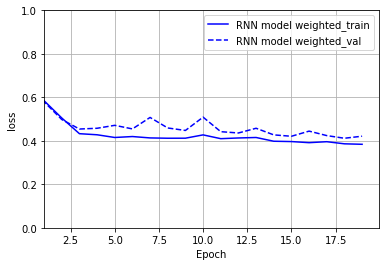

In [ ]:
plotter(m_histories, ylim=[0.0, 1], metric = 'loss')

### Testing

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = np.array([])
y_trues= np.array([])

# iterate through test set, make predictions based on trained model
for input_example_batch, target_example_batch in ds_series_batch_test:

  pred=model_cb.predict_on_batch(input_example_batch)
  pred_max=tf.argmax(tf.nn.softmax(pred),2).numpy().flatten()
  y_true=target_example_batch.numpy().flatten()

  preds=np.concatenate([preds,pred_max])
  y_trues=np.concatenate([y_trues,y_true])

# remove padding from evaluation
remove_padding = [(p,y) for p,y in zip(preds,y_trues) if y!=0 and p!=0]

r_p = [x[0] for x in remove_padding]
r_t = [x[1] for x in remove_padding]

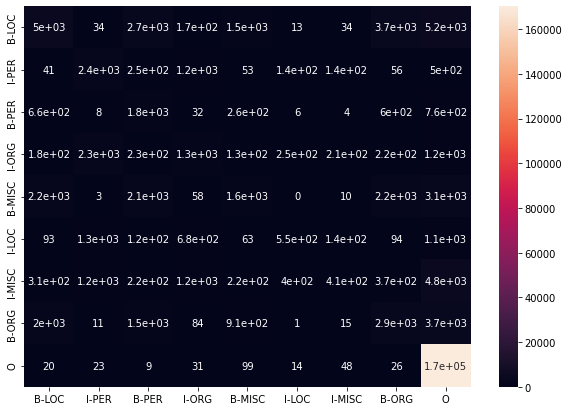

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
conf_mat = confusion_matrix(r_p,r_t)
df_cm = pd.DataFrame(conf_mat, 
                     index=list(idx2label.tolist()),
                     columns=list(idx2label.tolist()))
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)
plt.show()

In [ ]:
print(classification_report(r_p,r_t,target_names=list(idx2label.tolist()) ))

              precision    recall  f1-score   support

       B-LOC       0.48      0.27      0.35     18382
       I-PER       0.33      0.51      0.40      4770
       B-PER       0.20      0.44      0.28      4156
       I-ORG       0.28      0.22      0.25      6006
      B-MISC       0.33      0.14      0.20     11262
       I-LOC       0.40      0.13      0.20      4127
      I-MISC       0.40      0.04      0.08      9043
       B-ORG       0.29      0.26      0.28     11194
           O       0.89      1.00      0.94    170479

    accuracy                           0.78    239419
   macro avg       0.40      0.34      0.33    239419
weighted avg       0.74      0.78      0.75    239419

